## Reading scraped dataset

In [19]:
import pandas as pd

CSV_PLAIN_NAMES = ['Title', 'Author', 'CoverURL', 'Length', 'Listeners', 'Released', 'Tags']

df = pd.read_csv('../files/albums_plain.tsv', names=CSV_PLAIN_NAMES, sep='\t')

df.head()

,Title,Author,CoverURL,Length,Listeners,Released,Tags
0,UNDERTALE Soundtrack,Toby Fox,https://lastfm.freetls.fastly.net/i/u/300x300/...,101.0,710326.0,1.442264e+12,"[""instrumental"",""soundtrack"",""undertale"",""vide..."
1,Euphoria (Original Score from the HBO Series),Labrinth,https://lastfm.freetls.fastly.net/i/u/300x300/...,26.0,1089647.0,1.570050e+12,"[""pop"",""soundtrack"",""2019"",""psychedelic"",""elec..."
2,"Steven Universe, Vol. 1 (Original Soundtrack)",Steven Universe,https://lastfm.freetls.fastly.net/i/u/300x300/...,37.0,538706.0,1.496264e+12,"[""soundtrack"",""steven universe"",""pop"",""alterna..."
3,PERSONA5 ORIGINAL SOUNDTRACK,アトラスサウンドチーム,https://lastfm.freetls.fastly.net/i/u/300x300/...,NaN,261353.0,NaN,"[""acid jazz"",""lounge"",""jazz-funk"",""japanese"",""..."
4,The Elder Scrolls V: Skyrim: Original Game Sou...,Jeremy Soule,https://lastfm.freetls.fastly.net/i/u/300x300/...,53.0,341894.0,1.320955e+12,"[""ambient"",""soundtrack"",""instrumental"",""video ..."


## Download images and localy reference them in dataset

In [20]:
from pandarallel import pandarallel

COVER_FILES_PATH = '../files/images/'

def download_image(url, folder_path=COVER_FILES_PATH):
    import os
    import requests
    from urllib.parse import urlparse
    try:
        parsed_url = urlparse(url)
        filename = os.path.basename(parsed_url.path)  # Get the file name from the URL
        file_path = os.path.join(folder_path, filename)

        if not os.path.exists(file_path):
            response = requests.get(url, stream=True)
            response.raise_for_status()  # Ensure the request was successful
            # Save the image to the folder
            with open(file_path, 'wb') as f:
                f.write(response.content)
                
        return file_path  # Return the local file path
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        return None
    
import os
os.makedirs(COVER_FILES_PATH, exist_ok=True)

pandarallel.initialize(progress_bar=True)

df['Cover'] = df['CoverURL'].parallel_apply(download_image)

df.drop(columns=['CoverURL'], inplace=True)

df.head()

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


,Title,Author,Length,Listeners,Released,Tags,Cover
0,UNDERTALE Soundtrack,Toby Fox,101.0,710326.0,1.442264e+12,"[""instrumental"",""soundtrack"",""undertale"",""vide...",../files/images/bef3b7367a786c6a4299894d930c7d...
1,Euphoria (Original Score from the HBO Series),Labrinth,26.0,1089647.0,1.570050e+12,"[""pop"",""soundtrack"",""2019"",""psychedelic"",""elec...",../files/images/3d8fa60c989b138ca95cc564ae19e1...
2,"Steven Universe, Vol. 1 (Original Soundtrack)",Steven Universe,37.0,538706.0,1.496264e+12,"[""soundtrack"",""steven universe"",""pop"",""alterna...",../files/images/c085b052d051ae544eebbab0b3d571...
3,PERSONA5 ORIGINAL SOUNDTRACK,アトラスサウンドチーム,NaN,261353.0,NaN,"[""acid jazz"",""lounge"",""jazz-funk"",""japanese"",""...",../files/images/8a661f6b143a73ff2ced3b29f3ba86...
4,The Elder Scrolls V: Skyrim: Original Game Sou...,Jeremy Soule,53.0,341894.0,1.320955e+12,"[""ambient"",""soundtrack"",""instrumental"",""video ...",../files/images/f31a121762aa293471e88533ec3d6a...


## Classify genre


In [21]:
from enum import Enum

class Genre(Enum):
    POP = 'pop'
    HIPHOP = 'hip-hop'
    ROCK = 'rock' 
    RHYTHMBLUES = 'rhythm-blues'
    SOUL = 'soul'
    COUNTRY = 'country'
    FUNK = 'funk'
    FOLK = 'folk'
    JAZZ = 'jazz'
    DISCO = 'disco'
    INSTRUMENTAL = 'instrumental'
    AI = 'ai'
    BLUES = 'blues'
    ELECTRONIC = 'electronic'
    AMBIENT = 'ambient'
    PUNK = 'punk'
    OPERA = 'opera'
    ALTERNATIVE = 'alternative'
    ANIME = 'anime'
    SOUNDTRACK = 'soundtrack'

REGEX_TO_GENRE = {
    'pop': Genre.POP, 
    'hiphop': Genre.HIPHOP,
    'rock': Genre.ROCK,
    '(rhythm)(blues)?': Genre.RHYTHMBLUES,
    'soul': Genre.SOUL,
    'country': Genre.COUNTRY,
    'funk': Genre.COUNTRY,
    'folk': Genre.FOLK,
    'jazz': Genre.JAZZ,
    'disco': Genre.DISCO,
    '(classical)|(instrumental)|(symphonic)': Genre.INSTRUMENTAL,
    'ai': Genre.AI,
    'blues': Genre.BLUES,
    'electronic': Genre.ELECTRONIC,
    'ambient': Genre.AMBIENT,
    'punk': Genre.PUNK,
    'opera': Genre.OPERA,
    'alternative': Genre.ALTERNATIVE,
    'anime': Genre.ANIME
}

def normalize_tag(tag: str):
    import string
    tag = tag.lower().replace(' ', '')
    return tag.translate(tag.maketrans('', '', string.punctuation))

def scrap_genre(line):
    import json
    tags = ' '.join(map(normalize_tag, json.loads(line)))

    for r, genre in REGEX_TO_GENRE.items():
        regex = f'\\S*{r}\\S*'
        from re import search
        if search(regex, tags):
            return genre
        
    # It's atleast soundtrack
    return Genre.SOUNDTRACK

df['Genre'] = df['Tags'].apply(scrap_genre)

df.drop(columns=['Tags'], inplace=True)

df['Genre'].value_counts()

Genre
Genre.SOUNDTRACK      3282
Genre.INSTRUMENTAL    2565
Genre.POP             1714
Genre.ROCK             935
Genre.JAZZ             383
Genre.ELECTRONIC       249
Genre.FOLK             157
Genre.HIPHOP           138
Genre.COUNTRY          130
Genre.ANIME            118
Genre.AI                94
Genre.AMBIENT           94
Genre.SOUL              61
Genre.DISCO             26
Genre.RHYTHMBLUES       25
Genre.ALTERNATIVE       14
Genre.BLUES              8
Genre.PUNK               5
Genre.OPERA              2
Name: count, dtype: int64

## Normalize release year

In [22]:
df['Released'] = pd.to_datetime(df['Released'], unit='s', errors='coerce').dt.year

def normalize_df(df):
    df.fillna(df.mean(), inplace=True)

    min_v = df.min()
    max_v = df.max()

    df = (df - min_v) / (max_v - min_v)
    return df

df['Released'] = normalize_df(df['Released'])

df.head()

,Title,Author,Length,Listeners,Released,Cover,Genre
0,UNDERTALE Soundtrack,Toby Fox,101.0,710326.0,0.571429,../files/images/bef3b7367a786c6a4299894d930c7d...,Genre.INSTRUMENTAL
1,Euphoria (Original Score from the HBO Series),Labrinth,26.0,1089647.0,0.571429,../files/images/3d8fa60c989b138ca95cc564ae19e1...,Genre.POP
2,"Steven Universe, Vol. 1 (Original Soundtrack)",Steven Universe,37.0,538706.0,0.571429,../files/images/c085b052d051ae544eebbab0b3d571...,Genre.POP
3,PERSONA5 ORIGINAL SOUNDTRACK,アトラスサウンドチーム,NaN,261353.0,0.571429,../files/images/8a661f6b143a73ff2ced3b29f3ba86...,Genre.COUNTRY
4,The Elder Scrolls V: Skyrim: Original Game Sou...,Jeremy Soule,53.0,341894.0,0.571429,../files/images/f31a121762aa293471e88533ec3d6a...,Genre.SOUL


## Classify by type (Single [1-2], EP [3-5], Album [>5])

### Fill the nans in length by median of the same genre album

In [23]:
def fillna_length_by_genre_mean(df):

    mean = df.groupby('Genre', sort=False)['Length'].transform('median').round(0)

    df['Length'].fillna(mean, inplace=True)

fillna_length_by_genre_mean(df)

df['Length'].value_counts()

C:\Users\deyte\AppData\Local\Temp\ipykernel_17548\2206357153.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Length'].fillna(mean, inplace=True)


Length
18.0     3584
15.0      966
16.0      710
14.0      355
12.0      331
         ... 
109.0       1
116.0       1
173.0       1
197.0       1
344.0       1
Name: count, Length: 117, dtype: int64

### Classify type

In [24]:
class Type(Enum):
    SINGLE = 'single'
    EP = 'ep'
    ALBUM = 'album'

def classify_type(length):
    if length <= 2:
        return Type.SINGLE
    elif 3 <= length <= 4:
        return Type.EP
    else:
        return Type.ALBUM
    
df['Type'] = df['Length'].apply(classify_type)

df['Type'].value_counts()

df.head()

,Title,Author,Length,Listeners,Released,Cover,Genre,Type
0,UNDERTALE Soundtrack,Toby Fox,101.0,710326.0,0.571429,../files/images/bef3b7367a786c6a4299894d930c7d...,Genre.INSTRUMENTAL,Type.ALBUM
1,Euphoria (Original Score from the HBO Series),Labrinth,26.0,1089647.0,0.571429,../files/images/3d8fa60c989b138ca95cc564ae19e1...,Genre.POP,Type.ALBUM
2,"Steven Universe, Vol. 1 (Original Soundtrack)",Steven Universe,37.0,538706.0,0.571429,../files/images/c085b052d051ae544eebbab0b3d571...,Genre.POP,Type.ALBUM
3,PERSONA5 ORIGINAL SOUNDTRACK,アトラスサウンドチーム,18.0,261353.0,0.571429,../files/images/8a661f6b143a73ff2ced3b29f3ba86...,Genre.COUNTRY,Type.ALBUM
4,The Elder Scrolls V: Skyrim: Original Game Sou...,Jeremy Soule,53.0,341894.0,0.571429,../files/images/f31a121762aa293471e88533ec3d6a...,Genre.SOUL,Type.ALBUM


## Normalize length

<Axes: >

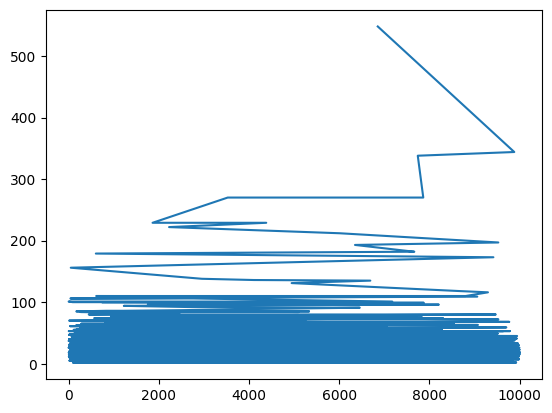

In [25]:
df['Length'].sort_values().plot()

<Axes: >

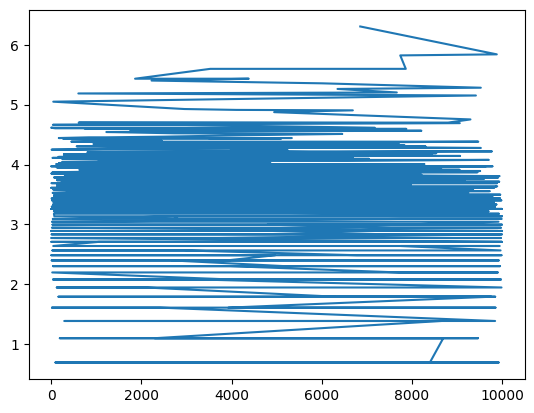

In [26]:
import numpy as np

df['Length'] = np.log(df['Length'])

df['Length'].sort_values().plot()

In [27]:
df['Length'] = normalize_df(df['Length'])

## Normalize listeners column

<Axes: >

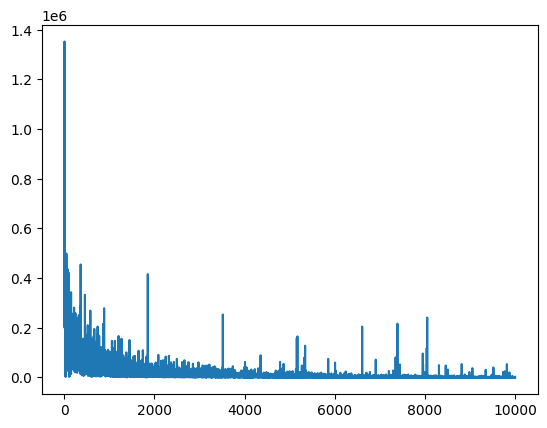

In [28]:
df['Listeners'].plot()

In [29]:
df['Listeners'] = normalize_df(df['Listeners'])

df.head()

,Title,Author,Length,Listeners,Released,Cover,Genre,Type
0,UNDERTALE Soundtrack,Toby Fox,0.698714,0.525116,0.571429,../files/images/bef3b7367a786c6a4299894d930c7d...,Genre.INSTRUMENTAL,Type.ALBUM
1,Euphoria (Original Score from the HBO Series),Labrinth,0.456955,0.805533,0.571429,../files/images/3d8fa60c989b138ca95cc564ae19e1...,Genre.POP,Type.ALBUM
2,"Steven Universe, Vol. 1 (Original Soundtrack)",Steven Universe,0.519812,0.398244,0.571429,../files/images/c085b052d051ae544eebbab0b3d571...,Genre.POP,Type.ALBUM
3,PERSONA5 ORIGINAL SOUNDTRACK,アトラスサウンドチーム,0.391444,0.193207,0.571429,../files/images/8a661f6b143a73ff2ced3b29f3ba86...,Genre.COUNTRY,Type.ALBUM
4,The Elder Scrolls V: Skyrim: Original Game Sou...,Jeremy Soule,0.583836,0.252748,0.571429,../files/images/f31a121762aa293471e88533ec3d6a...,Genre.SOUL,Type.ALBUM


In [30]:
## Convert emumerical types to string representation

In [31]:
df['Genre'] = df['Genre'].apply(lambda value: value.value)

df.head()

,Title,Author,Length,Listeners,Released,Cover,Genre,Type
0,UNDERTALE Soundtrack,Toby Fox,0.698714,0.525116,0.571429,../files/images/bef3b7367a786c6a4299894d930c7d...,instrumental,Type.ALBUM
1,Euphoria (Original Score from the HBO Series),Labrinth,0.456955,0.805533,0.571429,../files/images/3d8fa60c989b138ca95cc564ae19e1...,pop,Type.ALBUM
2,"Steven Universe, Vol. 1 (Original Soundtrack)",Steven Universe,0.519812,0.398244,0.571429,../files/images/c085b052d051ae544eebbab0b3d571...,pop,Type.ALBUM
3,PERSONA5 ORIGINAL SOUNDTRACK,アトラスサウンドチーム,0.391444,0.193207,0.571429,../files/images/8a661f6b143a73ff2ced3b29f3ba86...,country,Type.ALBUM
4,The Elder Scrolls V: Skyrim: Original Game Sou...,Jeremy Soule,0.583836,0.252748,0.571429,../files/images/f31a121762aa293471e88533ec3d6a...,soul,Type.ALBUM


## Represent Type by onehot since Genre is target trait

In [32]:
df['Single'] = df['Type'].apply(lambda x: 1 if x == Type.SINGLE else 0)
df['Album'] = df['Type'].apply(lambda x: 1 if x == Type.ALBUM else 0)
df['EP'] = df['Type'].apply(lambda x: 1 if x == Type.EP else 0)

# Drop the original 'Type' column
df.drop('Type', axis=1, inplace=True)

df.head()

,Title,Author,Length,Listeners,Released,Cover,Genre,Single,Album,EP
0,UNDERTALE Soundtrack,Toby Fox,0.698714,0.525116,0.571429,../files/images/bef3b7367a786c6a4299894d930c7d...,instrumental,0,1,0
1,Euphoria (Original Score from the HBO Series),Labrinth,0.456955,0.805533,0.571429,../files/images/3d8fa60c989b138ca95cc564ae19e1...,pop,0,1,0
2,"Steven Universe, Vol. 1 (Original Soundtrack)",Steven Universe,0.519812,0.398244,0.571429,../files/images/c085b052d051ae544eebbab0b3d571...,pop,0,1,0
3,PERSONA5 ORIGINAL SOUNDTRACK,アトラスサウンドチーム,0.391444,0.193207,0.571429,../files/images/8a661f6b143a73ff2ced3b29f3ba86...,country,0,1,0
4,The Elder Scrolls V: Skyrim: Original Game Sou...,Jeremy Soule,0.583836,0.252748,0.571429,../files/images/f31a121762aa293471e88533ec3d6a...,soul,0,1,0


## Save csv

In [33]:
df.to_csv(r'../files/albums_normalized.tsv', sep='\t')

## Save arff

In [34]:
import arff

arff_data = {
    'relation': 'soundtracks',
    'attributes': [
        ('Title', 'STRING'),
        ('Author', 'STRING'),
        ('Length', 'NUMERIC'),
        ('Listeners', 'NUMERIC'),
        ('Released', 'NUMERIC'),
        ('Cover', 'STRING'),
        ('Genre', [e.value for e in Genre]),
        ('Single', ['0', '1']),
        ('Album', ['0', '1']),
        ('EP', ['0', '1'])
    ],
    'data': df.values.tolist()  # Convert DataFrame rows to a list of lists
}

with open(r'../files/albums_normalized.arff', 'w', encoding='utf-8') as f:
    arff.dump(arff_data, f)